<h1 align="center" style="color:blue"> Anomaly Detection in Discounts  </h1>

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv("MLHW.csv")
df.shape

(1858329, 11)

In [4]:
df.columns

Index(['date', 'product_code', 'market', 'customer_code', 'qty', 'fiscal_year',
       'gross_sales_amt', 'net_sales_amt', 'total_cogs_amt',
       'gross_margin_amt', 'Total_discs'],
      dtype='object')

<h2 align="center" style="color:blue"> Feature Selection </h2>

Total_discs (main variable for anomaly detection)

gross_sales_amt (to see discount % relative to sales)

net_sales_amt (post-discount sales)

qty (to catch if high discount is tied to bulk sales)

<h2 align="center" style="color:blue"> Feature Engineering </h2>

In [10]:
df['discount_pct'] = (df['Total_discs'] / df['gross_sales_amt']) * 100
df['discount_pct'] = df['discount_pct'].fillna(0)

<h2 align="center" style="color:blue"> Scaling </h2>

In [15]:
from sklearn.preprocessing import StandardScaler

features = ['discount_pct', 'qty', 'gross_sales_amt', 'net_sales_amt']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

#### Isolation Forest

Isolation Forest is an unsupervised machine learning algorithm for anomaly detection.
Anomalies get isolated in fewer splits because they’re far away from most data.                                                      
Works well on tabular numeric data → Your discount %, qty, sales, costs are perfect for this.

Handles large datasets efficiently → You have 1.85M rows; Isolation Forest is built for this scale.

Captures multivariate anomalies → It will detect not just “discount > 80%” but also “discount is high compared to typical qty & product behavior.

Isolation Forest uses patterns across multiple features:

If a high discount comes with a huge qty → could be normal (bulk promo)

If a high discount comes with a small qty → suspicious

If a high discount appears in a product that has never been discounted → suspicious

This context-based filtering is where ML beats a static rule.

In [21]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Fill NaN with 0 before scaling
df[features] = df[features].fillna(0)

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Isolation Forest
from sklearn.ensemble import IsolationForest
iso = IsolationForest(
    n_estimators=100,
    contamination=0.01,  # 1% anomalies
    random_state=42
)

df['anomaly_flag'] = iso.fit_predict(X_scaled)  # -1 = anomaly, 1 = normal

In [31]:
pd.set_option('display.float_format', '{:.2f}'.format)

print(df['discount_pct'].describe())

count   1858329.00
mean         49.35
std           6.74
min           0.00
25%          45.01
50%          49.72
75%          54.25
max          68.48
Name: discount_pct, dtype: float64


<h2 align="center" style="color:blue"> Threshold to determine Anomaly </h2>

In [33]:
threshold = df['discount_pct'].quantile(0.99)  # 99th percentile
print(threshold)

62.46252743756972


In [37]:
anomalies = df[(df['anomaly_flag'] == -1) & (df['discount_pct'] > threshold)]
anomalies

,date,product_code,market,customer_code,qty,fiscal_year,gross_sales_amt,net_sales_amt,total_cogs_amt,gross_margin_amt,Total_discs,discount_pct,anomaly_flag
240243,2019-09-01,A7219160201,South Korea,80007195,1582,2020,44950.95,16869.43,13945.46,2923.96,28081.52,62.47,-1
303844,2019-11-01,A6218160101,South Korea,80007196,2317,2020,31745.45,11785.72,9782.93,2002.79,19959.73,62.87,-1
304315,2019-11-01,A6319160201,South Korea,80007196,2473,2020,40801.53,14724.72,12863.23,1861.49,26076.81,63.91,-1
317970,2019-11-01,A3320150503,South Korea,80007196,1604,2020,30255.61,10784.90,9651.87,1133.03,19470.71,64.35,-1
322258,2019-11-01,A2319150303,South Korea,80007196,1878,2020,17257.32,6274.21,5231.96,1042.26,10983.10,63.64,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1781221,2022-07-01,A1521150601,Philiphines,80006155,540,2022,106942.03,38166.19,33185.07,4981.12,68775.84,64.31,-1
1781535,2022-07-01,A1521150603,Philiphines,80006155,455,2022,97613.74,33054.06,30056.34,2997.71,64559.69,66.14,-1
1835189,2022-08-01,A1521150601,Philiphines,80006155,385,2022,76245.71,28218.13,23692.76,4525.36,48027.58,62.99,-1
1847355,2022-08-01,A6018110103,Philiphines,80006155,141,2022,119880.30,43835.47,36374.68,7460.78,76044.83,63.43,-1


<h2 align="center" style="color:blue"> Visualizing Anomalies </h2>

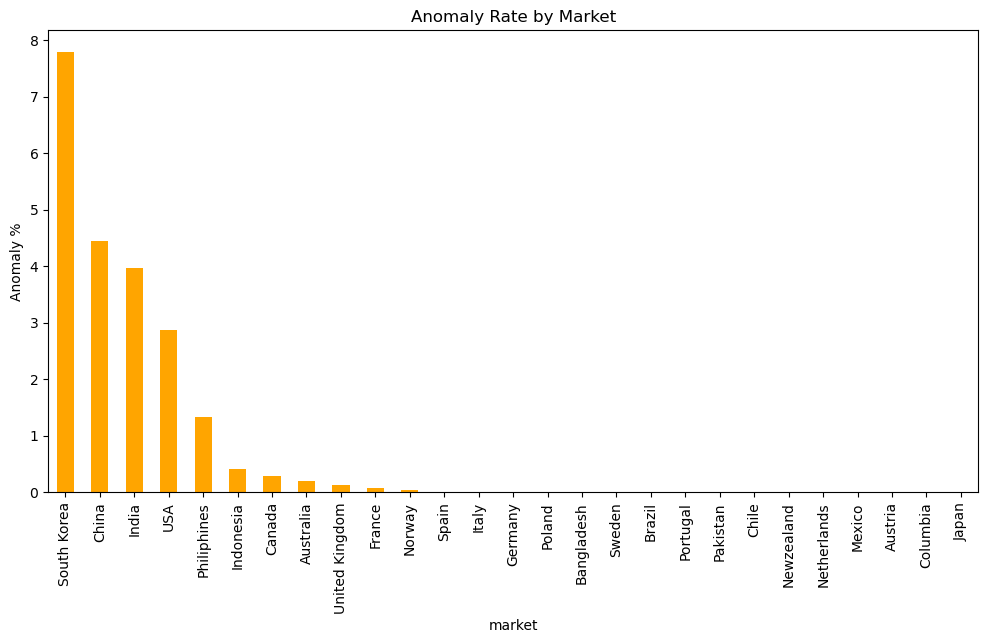

In [44]:
#Market/Product-level Anomaly Rate
import seaborn as sns

anomaly_rate = (
    df.groupby('market')['anomaly_flag']
      .apply(lambda x: (x==-1).mean()*100)
      .sort_values(ascending=False)
)

plt.figure(figsize=(12,6))
anomaly_rate.plot(kind='bar', color='orange')
plt.ylabel("Anomaly %")
plt.title("Anomaly Rate by Market")
plt.show()